# 1D Inversion for 1D Data

Here, we invert secondary magnetic field data for a single 1D FDEM sounding.

In [355]:
import numpy as np
import matplotlib.pyplot as plt

from discretize import TensorMesh

import SimPEG.electromagnetics.frequency_domain as fdem
from SimPEG.utils import mkvc, plot_1d_layer_model
from SimPEG import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
)

import sys
sys.path.append("../")
from inversion_toolkit.model_functions import get_1d_model

import discretize
m_true = np.load("../models/2d-model-array.npy")
inversion_mesh_2d = discretize.load_mesh("../meshes/inversion_mesh_2d.json")

## Load Data and Plot

In [356]:
# path to the directory containing our data
dir_path = "./1d_simulation_data/"

In [357]:
# Choose which side data to work with
side = "left" # "right" or "left"

if side == "left":
    data_filename = dir_path + "em1dfm_data_left.txt"
    x_position = 0
elif side == "right":
    data_filename = dir_path + "em1dfm_data_right.txt"
    x_position = 10000
else:
    print("Invalid side chosen: No data")

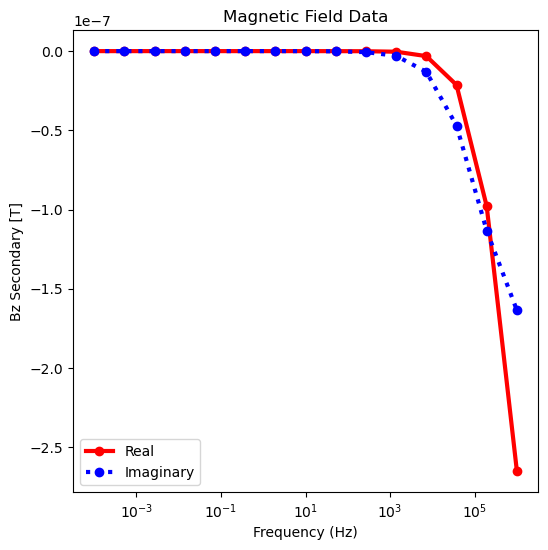

In [358]:
dobs = np.loadtxt(str(data_filename), skiprows=1)

# Define receiver locations and observed data
frequencies = dobs[:, 0]
dobs = mkvc(dobs[:, 1:].T)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.semilogx(frequencies, (dobs[0::2]), "r-o", lw=3)
ax.semilogx(frequencies, (dobs[1::2]), "b:o", lw=3)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Bz Secondary [T]")
ax.set_title("Magnetic Field Data")
ax.legend(["Real", "Imaginary"])
plt.show()

## Defining the Survey

In [359]:
source_location = np.array([0.0, 0.0, 30.0])
moment = 1.0

receiver_location = np.array([10.0, 0.0, 30.0])
receiver_orientation = "z"

# Receiver list
receiver_list = []
receiver_list.append(
    fdem.receivers.PointMagneticFluxDensitySecondary(
        receiver_location,
        orientation=receiver_orientation,
        component="real",
    )
)
receiver_list.append(
    fdem.receivers.PointMagneticFluxDensitySecondary(
        receiver_location,
        orientation=receiver_orientation,
        component="imag",
    )
)

# Define source list
source_list = []
for freq in frequencies:
    source_list.append(
        fdem.sources.MagDipole(
            receiver_list=receiver_list,
            frequency=freq,
            location=source_location,
            orientation="z",
            moment=moment,
        )
    )

# Survey
survey = fdem.survey.Survey(source_list)

## Assign Uncertainties

A percent uncertainty between 5% and 20% may be applied.

In [360]:
# 5% of the absolute value
uncertainties = 0.05 * np.abs(dobs) * np.ones(np.shape(dobs))

## Defining the Data

In [361]:
data_object = data.Data(survey, dobs=dobs, noise_floor=uncertainties)

## Weighted Least-Squares Inversion

Here, we use the weighted least-squares inversion approach to recover the log-resistivity on a 1D layered Earth. We impose no a-priori information about the number of layers (geological units) or their thicknesses. Instead, we define a large number of layers with exponentially increasing thicknesses. And the depth, thickness and electrical properties of the Earth are inferred from the recovered model.

### Defining a 1D Layered Earth (1D Tensor Mesh)

First assuming we have a reasonable estimate of the regional coductivity ($\sigma$) within our are of interest, estimate maximum and minimum skin depth:

$$d \approx 500\sqrt{\frac{1}{\sigma f}} = 500\sqrt{\frac{\rho}{f}} $$

In [362]:
# estimated host conductivity (S/m)
estimated_resistivity = 100

# minimum skin depth
d_min = 500.0 * np.sqrt(estimated_resistivity/ frequencies.max())
print("MINIMUM SKIN DEPTH: {} m".format(d_min))

# maximum skin depth
d_max = 500.0 * np.sqrt(estimated_resistivity/ frequencies.min())
print("MAXIMUM SKIN DEPTH: {} m".format(d_max))

MINIMUM SKIN DEPTH: 5.0 m
MAXIMUM SKIN DEPTH: 500000.0 m


In [363]:
depth_min = 50  # top layer thickness
depth_max = 5000.0  # depth to lowest layer
geometric_factor = 1.1  # rate of thickness increase

In [364]:
# Increase subsequent layer thicknesses by the geometric factors until
# it reaches the maximum layer depth.
layer_thicknesses = [depth_min]
while np.sum(layer_thicknesses) < depth_max:
    layer_thicknesses.append(geometric_factor * layer_thicknesses[-1])

n_layers = len(layer_thicknesses) + 1  # Number of layers
print("n_layers: ", n_layers)

n_layers:  27


### Model and Mapping to Layer Conductivities

In [365]:
log_resistivity_map = maps.ExpMap(nP=n_layers)

### Define a Starting and/or Reference Model and the Mapping

Here, we create starting and/or reference models for the inversion as
well as the mapping from the model space to the active cells. Starting and
reference models can be a constant background value or contain a-priori
structures. Here, the starting model is log(estimated_resistivity) S/m.

Define log-resistivity values for each layer since our model is the
log-resistivity.



In [366]:
# Starting model is log-conductivity values (S/m)
starting_resistivity_model = np.log((estimated_resistivity) * np.ones(n_layers))

# Reference model is also log-resistivity values (S/m)
reference_resistivity_model = starting_resistivity_model.copy()

### Define the Physics using Simulation Object

In [367]:
simulation_L2 = fdem.Simulation1DLayered(
    survey=survey, thicknesses=layer_thicknesses, rhoMap=log_resistivity_map
)

### Define Inverse Problem

The inverse problem is defined by 3 things:

    1) Data Misfit: a measure of how well our recovered model explains the field data
    2) Regularization: constraints placed on the recovered model and a priori information
    3) Optimization: the numerical approach used to solve the inverse problem

In [368]:
# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# The weighting is defined by the reciprocal of the uncertainties.
dmis_L2 = data_misfit.L2DataMisfit(simulation=simulation_L2, data=data_object)

In [369]:
# Define 1D cell widths
h = np.r_[layer_thicknesses, layer_thicknesses[-1]]
h = np.flipud(h)

# Create regularization mesh
regularization_mesh = TensorMesh([h], "N")
print(regularization_mesh)


  TensorMesh: 27 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     27     -6,000.82          0.00     50.00    541.74    1.10




In [370]:
reg_L2 = regularization.WeightedLeastSquares(
    regularization_mesh,
    length_scale_x=10.0,
    reference_model=reference_resistivity_model,
    reference_model_in_smooth=False,
)

In [371]:
opt_L2 = optimization.InexactGaussNewton(
    maxIter=100, maxIterLS=20, maxIterCG=20, tolCG=1e-3
)

### Define Inversion Directives

Here we define any directiveas that are carried out during the inversion. This
includes the cooling schedule for the trade-off parameter (beta), stopping
criteria for the inversion and saving inversion results at each iteration.

In [372]:
inv_prob_L2 = inverse_problem.BaseInvProblem(dmis_L2, reg_L2, opt_L2)

In [373]:
update_jacobi = directives.UpdatePreconditioner(update_every_iteration=True)
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e0)
beta_schedule = directives.BetaSchedule(coolingFactor=2.0, coolingRate=3)
target_misfit = directives.TargetMisfit(chifact=1.0)

directives_list_L2 = [update_jacobi, 
                      starting_beta, 
                      beta_schedule, 
                      target_misfit]

In [374]:
# Here we combine the inverse problem and the set of directives
inv_L2 = inversion.BaseInversion(inv_prob_L2, directives_list_L2)

# Run the inversion
recovered_model_L2 = inv_L2.run(starting_resistivity_model)


                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0


   0  2.05e+01  2.36e+05  0.00e+00  2.36e+05    3.80e+05      0              
   1  2.05e+01  3.86e+04  4.81e+02  4.85e+04    3.83e+04      0              
   2  2.05e+01  1.29e+04  1.22e+03  3.78e+04    6.65e+03      0   Skip BFGS  
   3  1.02e+01  1.78e+04  9.60e+02  2.77e+04    1.58e+04      0              
   4  1.02e+01  7.40e+03  1.69e+03  2.47e+04    3.79e+03      0              
   5  1.02e+01  1.02e+04  1.41e+03  2.46e+04    3.13e+03      0              
   6  5.12e+00  8.33e+03  1.58e+03  1.64e+04    5.57e+03      0              
   7  5.12e+00  4.08e+03  2.23e+03  1.55e+04    1.51e+03      0              
   8  5.12e+00  5.28e+03  1.99e+03  1.55e+04    9.92e+02      0              
   9  2.56e+00  4.61e+03  2.12e+03  1.00e+04    3.50e+03      0              
  10  2.56e+00  2.10e+03  2.88e+03  9.46e+03    7.98e+02      0              
  11  2.56e+00  2.68e+03  2.64e+03  9.43e+03    4.65e+02      0              
  12  1.28e+00  2.39e+03  2.75e+03  5.91e+03    2.04e+03      0 

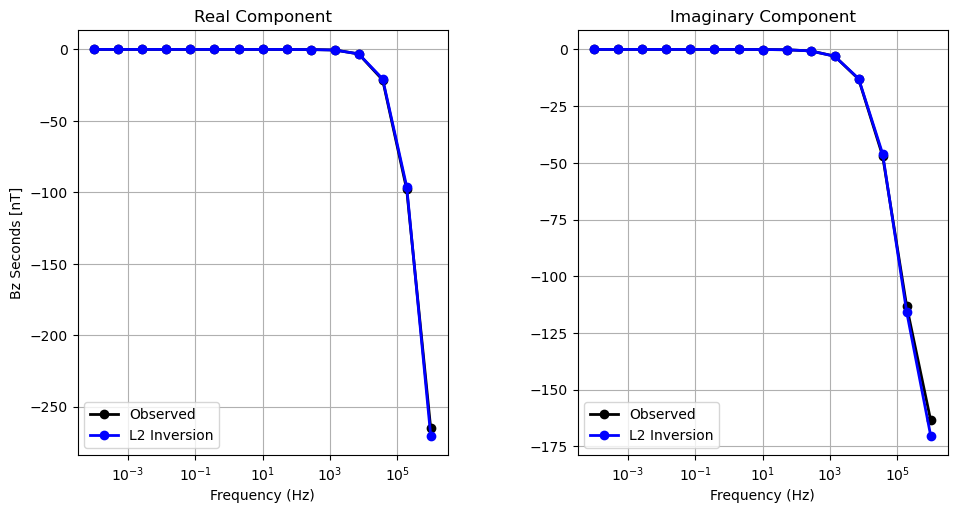

In [375]:
dpred_L2 = simulation_L2.dpred(recovered_model_L2)

fig = plt.figure(figsize=(10, 5))
ax = [fig.add_axes([0.1 + ii * 0.5, 0.1, 0.37, 0.85]) for ii in range(2)]
for ii in range(2):
    ax[ii].semilogx(frequencies, (10**9) *(dobs[ii::2]), "k-o", lw=2)
    ax[ii].semilogx(frequencies, (10**9) *(dpred_L2[ii::2]), "b-o", lw=2)
    ax[ii].grid(which="both")
    ax[ii].set_xlabel("Frequency (Hz)")
    ax[ii].set_ylabel("Bz Seconds [nT]")
    ax[ii].legend(["Observed", "L2 Inversion"])
    if ii == 1:
        ax[ii].set_ylabel("")

ax[0].set_title("Real Component")
ax[1].set_title("Imaginary Component")
plt.show()

In [376]:
# Get true models
true_layers,true_log_resistivity_map, true_log_resistivities,_ = get_1d_model(x_position=x_position, 
                                                                              m_true=m_true,
                                                                              inversion_mesh_2d=inversion_mesh_2d)
true_resistivities = true_log_resistivity_map*true_log_resistivities

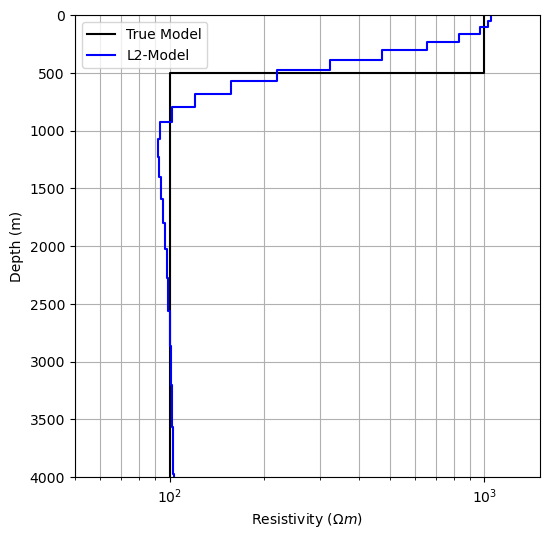

In [377]:
# Plot true model and recovered model
fig, ax = plt.subplots(1,1, figsize=(6, 6))

plot_1d_layer_model(true_layers, true_resistivities, scale="log", ax=ax, color="k")
plot_1d_layer_model(layer_thicknesses, log_resistivity_map * recovered_model_L2, ax=ax, color="b")
ax.grid(which="both")
ax.set_xlabel(r"Resistivity ($\Omega m$)")
x_min, x_max = true_resistivities.min(), true_resistivities.max()
ax.set_ylim([4000, 0])
ax.set_xlim(0.5 * x_min, 1.5 * x_max)
ax.legend(["True Model", "L2-Model"])
plt.show()